In [1]:
import numpy as np
import pandas as pd

# Generate example data for patients.csv and exams.csv
# Set seeds for reproducibility
np.random.seed(42)

# Create patients.csv
n_patients = 100
# Create ages with a distribution skewed toward older ages (more older patients)
ages = np.random.rand(n_patients) ** 2.5  # stronger skew, most values near 1 (older)
# Scale to age range 5-94
_ages = ages
scaled_ages = (_ages * (94 - 5) + 5).astype(int)

patients_df = pd.DataFrame({
    "patient_id": range(1, n_patients + 1),
    "name": [f"Patient_{i}" for i in range(1, n_patients + 1)],
    "age": scaled_ages,
    "gender": np.random.choice(["M", "F"], n_patients),
    "city": np.random.choice(["New York", "Los Angeles", "Chicago", "Houston", "Phoenix"], n_patients),
})
patients_df.to_csv("patients.csv", index=False)

# Create exams.csv (multiple exams per patient)
n_exams = 240
exams_df = pd.DataFrame({
    "exam_id": range(1, n_exams + 1),
    "patient_id": np.random.choice(range(1, n_patients + 1), n_exams),
    "exam_date": pd.date_range("2023-01-01", periods=n_exams, freq="6h"),  # use "6h" (lowercase) per deprecation warning
    "exam_type": np.random.choice(["Blood Test", "X-Ray", "MRI", "CT Scan", "Ultrasound"], n_exams),
    # Make result_value lower for older (higher age) - simulate an inverse relationship
    # Build patient_ids first, then map ages to those patient_ids before DataFrame creation
    # We can't reference exams_df here because it's not constructed yet,
    # so use patient_id array from above to map age for each row
    "result_value": 100 - (patients_df.set_index("patient_id").loc[
        # This repeats the patient ids that will be used in exams_df rows
        np.random.choice(range(1, n_patients + 1), n_exams)
    ]["age"].values + np.random.normal(0, 10, n_exams)),
    "status": np.random.choice(
        ["completed", "pending", "cancelled"], n_exams, p=[0.8, 0.15, 0.05]
    ),
})
exams_df.to_csv("exams.csv", index=False)


'flowchart TB\n\n    %% Node definitions\n    op_1[["<b>Merge (inner)</b><br/><i>INNER join on patient_id</i><br/>➡️ df_1: 100×5<br/>➡️ df_2: 240×6<br/>⬅️ 240 rows × 10 cols<br/>↑ +140 (+140.0%)<br/>────────────────────<br/>🔑 patient_id: 86 unique<br/>🔑 exam_date: 240 unique<br/>⭐ age: 43 unique<br/>mean=28.39 [5.0–91.0]<br/>"]]\n    op_2{"<b>Query</b><br/><i>Filter: age &gt;= 18</i><br/>➡️ df_1: 240×10<br/>⬅️ 121 rows × 10 cols<br/>↓ -119 (-49.6%)<br/>────────────────────<br/>🔑 patient_id: 43 unique<br/>🔑 exam_date: 121 unique<br/>⭐ age: 32 unique<br/>mean=48.46 [18.0–91.0]<br/>"}\n    op_2_removed[/"🗑️ Removed<br/>119 rows<br/>(49.6%)"/]\n    op_3["<b>Assign</b><br/><i>Create column(s): age_group</i><br/>➡️ df_1: 121×10<br/>⬅️ 121 rows × 11 cols<br/>────────────────────<br/>🔑 patient_id: 43 unique<br/>🔑 exam_date: 121 unique<br/>⭐ age: 32 unique<br/>mean=48.46 [18.0–91.0]<br/>"]\n    op_4>"<b>Drop Duplicates</b><br/><i>Remove duplicates on patient_id, exam_date</i><br/>➡️ df_1: 121×1
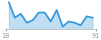
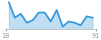
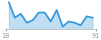
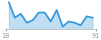

In [2]:
import pandas as pd

# --- Workaround for pandas_flow RecursionError during read_csv tracking ---
# Import pandas_flow, but only setup tracking *after* initial reads if you want to avoid recursion error
import pandas_flow

# Read CSVs before enabling pandas_flow tracking to avoid recursion with monkeypatch
patients = pd.read_csv("patients.csv")
exams = pd.read_csv("exams.csv")

# Now setup the tracker (tracking for subsequent operations only)
flow = pandas_flow.setup(
    track_row_count=True,
    track_variables={
        "patient_id": "n_unique",
        "exam_date": "n_unique",
    },
    stats_variable="age",
    stats_types=["min", "max", "mean", "std", "histogram"],
)

# Merge datasets
combined = patients.merge(exams, on="patient_id", how="inner")

# Filter adults
adults = combined.query("age >= 18")

# Add calculated columns
adults = adults.assign(
    age_group=lambda x: pd.cut(x["age"], bins=[18, 30, 50, 70, 100])
)

# Remove duplicates
clean_data = adults.drop_duplicates(subset=["patient_id", "exam_date"])

# Generate the flowchart
# HTML
html_path = "pipeline_flowchart.html"
flow.render(str(html_path), title="Patient Exam Pipeline")
